As a home baker and bread lover, I'm interested in improving the taste of my bread and since the microbial communities are what influences the flavors, I want to try and replicate conditions that are conducive for microbes that are associated with the flavors that I want. Naturally, I don't have access to PCR machines or sequencers, so I won't be doing any amplicon studies to characterise the microbes in my starter or be trying to do a monoculture of specific microbes. However, what I can adjust are things that all (or most) homes have: fridges (temperature), containers, flour type etc.

Obviously, the biggest factor on the microbes in a sourdough starter is the type of flour[<sup>1, </sup>](https://doi.org/10.1016/j.ijfoodmicro.2016.05.022)[<sup>2</sup>](https://doi.org/10.1016/j.ijfoodmicro.2018.08.009) and indeed the [paper](https://doi.org/10.7554/eLife.61644) whose data I'm using, did not find other external factors that strongly influence microbial composition of the starter. Therefore, it'd be best to try different flours but I don't want to end up with 10 different types of flour in my pantry and not having any use for 9 of them.

Besides, there are, **some** effects found that I can try to duplicate on my end. And here's where the data analysis comes in, I'm going to try and identify the microbes that are associated with notes I like and see if I can find the factors to encourage the growth of these microbes.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# I'll start by looking at the microbe data first

# read and transpose data since the variables (ASVs) are rows in the raw data
bact = pd.read_csv("sourdough_tab_16S.csv").set_index('Unnamed: 0').T.reset_index()
fung = pd.read_csv("sourdough_tab_ITS.csv").set_index('Unnamed: 0').T.reset_index()

# rename column and index for clarity
bact = bact.rename(columns={'index':'samples'}).rename_axis(None, axis=1)
fung = fung.rename(columns={'index':'samples'}).rename_axis(None, axis=1)

print(f'bacteria rel. abundance: {bact.shape}\nfungi rel. abundance: {fung.shape}')

bacteria rel. abundance: (500, 439)
fungi rel. abundance: (500, 1520)


<Axes: ylabel='samples'>

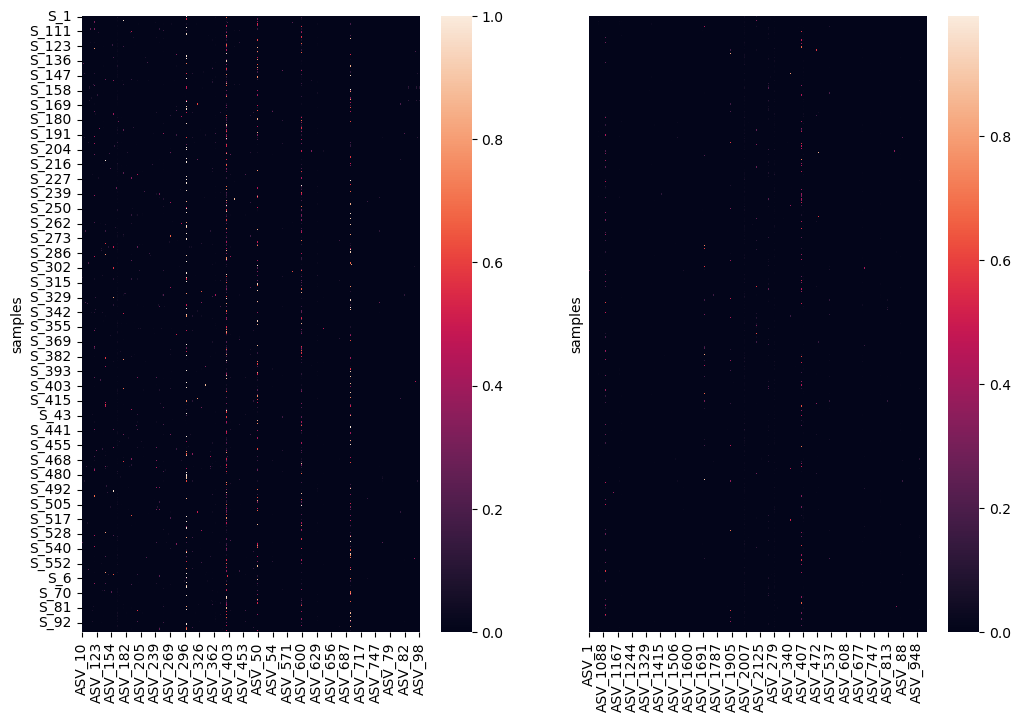

In [3]:
# plot the data to see the distribution of values

fig = plt.figure(figsize = (12, 8))

ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(data = bact.set_index('samples'), ax=ax1)

ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(data = fung.set_index('samples'), ax=ax2, yticklabels=False)


Its pretty clear the data is very sparse and some dimensionality reduction is needed as well. The simplest way would be to only analyse sourdough fermentation-relevant bacteria. I'm thinking that even though some bacteria are not relevant to sourdough, they might still be *associated* to the starter conditions. For example, non-relevant bacteria B may not ferment flour but if it prefers similar conditions as relevant bacteria A that produces a desirable flavor, then its abundance data is still useful information. 

In the 16s bacteria taxonomy data, there are actually a number of ASVs identified as the same species. It could be that these are different sub strains of the same species or even a different species and there are discussions [<sup>3,</sup>](https://forum.qiime2.org/t/how-should-different-asvs-of-the-same-species-be-interpreted/12394/2)[<sup>4</sup>](https://forum.qiime2.org/t/wouldnt-it-be-better-to-think-of-an-asv-as-a-distinct-16s-copy-rather-than-a-distinct-species/10776) on dealing with this. For this analysis, I'll assume similar species are associated with a starter's culture conditions and aggregate ASVs identified as the same species by summing their relative abundance for every sample. 

In [4]:
bact_tax = pd.read_csv("sourdough_tax_16S.csv")
fung_tax = pd.read_csv("sourdough_tax_ITS.csv")

In [5]:
# combine tax 6 and 7 to make a genus-species identifier for all ASVs
bact_tax['species'] = bact_tax['taxonomy6'] +"_"+ bact_tax['taxonomy7']
fung_tax['species'] = fung_tax['taxonomy6'].str.replace('g__', "") +"_"+ fung_tax['taxonomy7'].str.replace('s__', "")

# some ASVs are not identified at the genus/species level, use the ASV as an identifier instead
bact_tax['species'].fillna(bact_tax['taxonomy8'], inplace=True)
fung_tax['species'].fillna(fung_tax['taxonomy8'], inplace=True)

In [141]:
def aggregate_same_species(abund_df, tax_df):
    '''aggregate ASVs identified as the same species by summing their abundance, species of ASVs are referred from tax_df.
    '''
    
    # ensure ASVs is in the same order in both dfs
    assert sum(bact_tax['taxonomy8'] == bact.columns[1:]), "ASVs not in same order!"

    # collect ASVs with the same species
    from collections import defaultdict
    dict = defaultdict(list)
    for i in range(len(tax_df)):
        dict[tax_df['species'][i]].append(tax_df['taxonomy8'][i])

    # aggregate abundance data 
     
    new_df = abund_df.iloc[:, :1].copy()
    
    # sanity check for total ASVs
    n = 0
    for species in list(dict.keys()):
        col_names = list(new_df.columns) + [species]
        new_df = pd.concat([new_df, abund_df.loc[:, dict[species]].sum(axis=1)], axis=1)
        n += len(dict[species])
        new_df.columns = col_names

    # sanity check
    assert n == abund_df.shape[1]-1, 'not all ASVs collected, check outputs'

    return new_df

